✅ Successfully loaded 726 synchronized records from './synchronized_robot_camera_data_2.csv'
✅ Filtering out right-camera data. Kept 363 left-camera records out of 726.

--- Processing single entry (row 301 of filtered data) ---


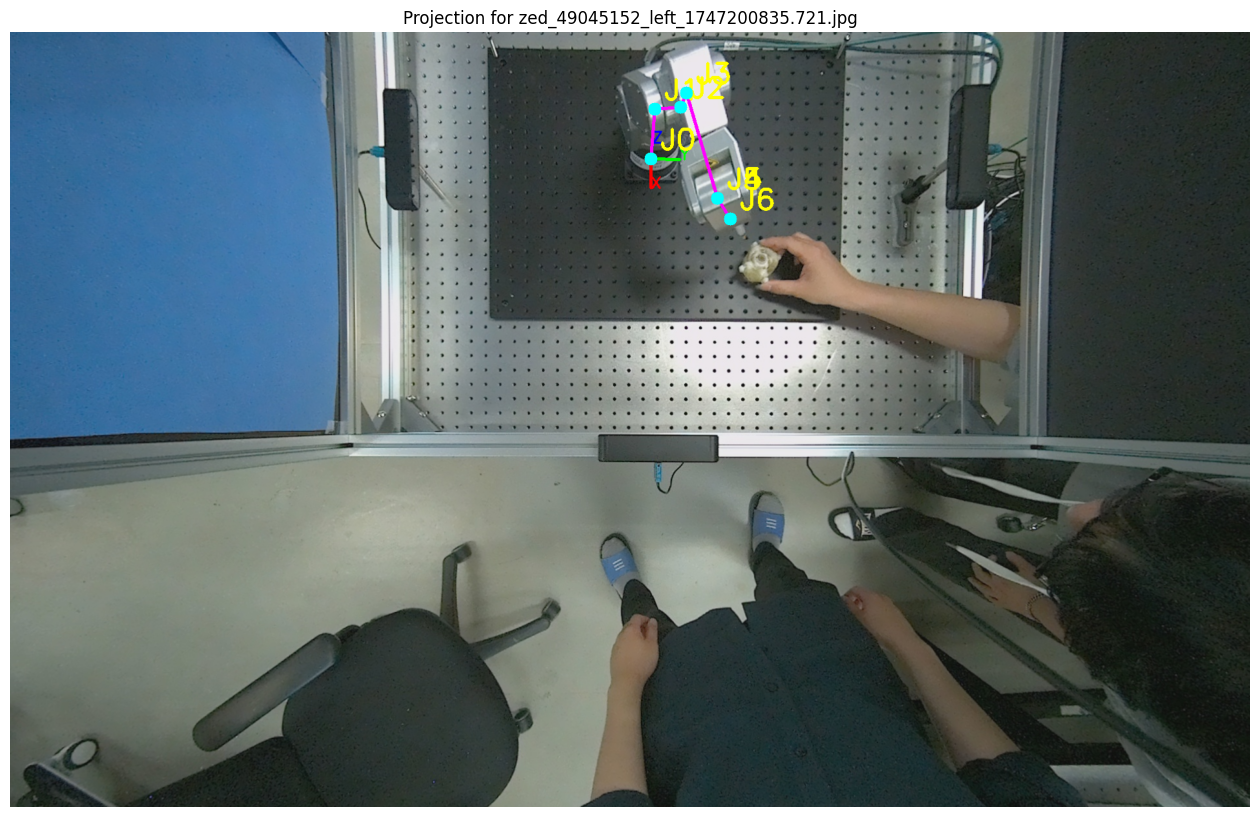

✅ 동기화된 데이터 726개 로드 완료.
✅ Left-camera 데이터 필터링 후 363개 남음.


라벨 생성 중: 100%|██████████| 363/363 [00:00<00:00, 981.51it/s]


✅ 라벨 생성 완료! 총 363개의 라벨 파일이 './3D_Coordinate_label/left' 폴더에 저장되었습니다.


In [4]:
import os
import json
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm # tqdm for progress bar in loop

# ===================================================================
# 1. 설정 (변경 없음)
# ===================================================================

# 동기화된 데이터 파일 경로 (첫 번째 스크립트의 출력)
SYNC_CSV_PATH = "./synchronized_robot_camera_data_2.csv" 

# ArUco 및 보정 데이터 경로 (이전과 동일)
ARUCO_PATH = './aruco_final_summary.json'
CALIB_DIR = "./Calib_cam_from_conf"

# 결과 이미지를 저장할 디렉토리 (모든 데이터를 처리할 경우 사용)
OUTPUT_VIS_DIR = "./synchronized_visualization"
os.makedirs(OUTPUT_VIS_DIR, exist_ok=True)

# ===================================================================
# 2. 데이터 로딩 함수 (변경 없음)
# ===================================================================
def load_data_from_sync_row(sync_row, aruco_summary_path, calib_dir):
    """
    동기화된 데이터프레임의 한 행(row)을 기반으로 필요한 모든 데이터를 로드.
    타임스탬프 검색 과정이 필요 없어짐.
    """
    image_path = sync_row['image_path']
    
    # 이미지 경로에서 카메라 정보 파싱
    image_name = os.path.basename(image_path)
    parts = image_name.split('_')
    serial_str = parts[1]
    serial_to_view = {"41182735": "front", "44377151": "left", "49429257": "right", "49045152": "top"}
    view = serial_to_view.get(serial_str)
    cam = parts[2] + "cam"
    if not view: raise ValueError(f"Unknown serial number: {serial_str}")
    
    # ArUco 결과 로드
    with open(aruco_summary_path, 'r') as f:
        aruco_results_all = json.load(f)
    aruco_result = next((item for item in aruco_results_all if item['view'] == view and item['cam'] == cam), None)
    if aruco_result is None:
        raise ValueError(f"No matching ArUco result found for {view}, {cam}")
        
    # 카메라 캘리브레이션 파일 로드
    calib_path = os.path.join(calib_dir, f"{view}_{serial_str}_{cam}_calib.json")
    with open(calib_path, 'r') as f:
        calib = json.load(f)
    camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
    
    return sync_row, image_path, aruco_result, camera_matrix, dist_coeffs

# ===================================================================
# 3. 순기구학 (Forward Kinematics) 계산 (변경 없음)
# ===================================================================
def get_dh_matrix(a, d, alpha, theta):
    """단일 DH 변환 행렬을 계산합니다."""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def forward_kinematics(joint_angles):
    """주어진 관절 각도에 대한 모든 조인트의 3D 좌표를 계산합니다."""
    dh_params = [
        {'alpha': -90, 'a': 0,     'd': 0.135, 'theta_offset': 0},
        {'alpha': 0,   'a': 0.135, 'd': 0,     'theta_offset': -90},
        {'alpha': -90, 'a': 0.038, 'd': 0,     'theta_offset': 0},
        {'alpha': 90,  'a': 0,     'd': 0.120, 'theta_offset': 0},
        {'alpha': -90, 'a': 0,     'd': 0,     'theta_offset': 0},
        {'alpha': 0,   'a': 0,     'd': 0.070, 'theta_offset': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)
    
    # 베이스 좌표계 보정 (X축 180도 회전 후 Z축 90도 추가 회전)
    T_base_correction = np.eye(4)
    rot_x_180 = R.from_euler('x', 180, degrees=True)
    rot_z_90 = R.from_euler('z', 90, degrees=True)
    combined_rotation = rot_z_90 * rot_x_180
    T_base_correction[:3, :3] = combined_rotation.as_matrix()

    T_cumulative = T_base_correction
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = dh_params[i]
        theta = joint_angles[i] + params['theta_offset']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

# ===================================================================
# 4. 좌표계 변환 및 투영 (변경 없음)
# ===================================================================
def transform_and_project(joint_coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """3D 관절 좌표를 카메라 좌표계로 변환 후 2D 이미지에 투영합니다."""
    rvec_deg = np.array([
        aruco_result.get('rvec_x_deg', 0), aruco_result.get('rvec_y_deg', 0), aruco_result.get('rvec_z_deg', 0)
    ], dtype=np.float32)
    rvec_rad = np.deg2rad(rvec_deg)
    tvec = np.array([
        aruco_result['mean_x'], aruco_result['mean_y'], aruco_result['mean_z']
    ], dtype=np.float32)
    R_matrix, _ = cv2.Rodrigues(rvec_rad)
    points_in_camera_frame = (R_matrix @ joint_coords_3d.T).T + tvec
    pixel_coords, _ = cv2.projectPoints(
        points_in_camera_frame, np.zeros(3), np.zeros(3), camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

# ===================================================================
# 5. 시각화 함수 (변경 없음)
# ===================================================================
def visualize_projection(image_path, pixel_coords, axis_pixel_coords, K, dist, title="Projected Robot Joints", output_path=None):
    """결과를 시각화하고, 필요시 파일로 저장합니다."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        return
        
    undistorted_img = cv2.undistort(image, K, dist, None, K)
    vis_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

    # 베이스 좌표축 그리기
    if axis_pixel_coords is not None and len(axis_pixel_coords) == 4:
        origin = tuple(axis_pixel_coords[0].astype(int))
        x_axis_end = tuple(axis_pixel_coords[1].astype(int))
        y_axis_end = tuple(axis_pixel_coords[2].astype(int))
        z_axis_end = tuple(axis_pixel_coords[3].astype(int))
        # X축 (빨간색)
        cv2.line(vis_img, origin, x_axis_end, (255, 0, 0), 3)
        cv2.putText(vis_img, 'X', x_axis_end, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        # Y축 (녹색)
        cv2.line(vis_img, origin, y_axis_end, (0, 255, 0), 3)
        cv2.putText(vis_img, 'Y', y_axis_end, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        # Z축 (파란색)
        cv2.line(vis_img, origin, z_axis_end, (0, 0, 255), 3)
        cv2.putText(vis_img, 'Z', z_axis_end, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # 관절 스켈레톤 그리기
    cv2.polylines(vis_img, [pixel_coords.astype(np.int32)], isClosed=False, color=(255, 0, 255), thickness=3)
    # 각 관절 위치에 원과 텍스트 그리기
    for i, (px, py) in enumerate(pixel_coords.astype(np.int32)):
        cv2.circle(vis_img, (px, py), 10, (0, 255, 255), -1)
        cv2.putText(vis_img, f"J{i}", (px + 15, py - 15), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 3)

    plt.figure(figsize=(16, 12))
    plt.imshow(vis_img)
    plt.title(title)
    plt.axis("off")
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        plt.close() # 창을 바로 닫음
    else:
        plt.show() # 화면에 보여줌

# ===================================================================
# 6. 메인 실행 로직 (수정됨)
# ===================================================================
if __name__ == '__main__':
    try:
        # 동기화된 데이터 로드
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        print(f"✅ Successfully loaded {len(df_sync)} synchronized records from '{SYNC_CSV_PATH}'")

        # ▼▼▼▼▼ [수정] rightcam 데이터 모두 제외 ▼▼▼▼▼
        # image_path에 '_left_' 문자열이 포함된 행만 남깁니다.
        # ZED 카메라 파일명 형식(..._left_... 또는 ..._right_...)을 이용합니다.
        original_count = len(df_sync)
        df_sync = df_sync[df_sync['image_path'].str.contains('_left_')]
        print(f"✅ Filtering out right-camera data. Kept {len(df_sync)} left-camera records out of {original_count}.")
        # ▲▲▲▲▲ [수정] 종료 ▲▲▲▲▲

        if df_sync.empty:
            print("No left-camera data found after filtering. Exiting.")
            exit()

        # --- 옵션 1: 하나의 샘플 데이터만 확인하기 ---
        ROW_INDEX_TO_TEST = 301 # 필터링된 데이터의 첫 번째 행을 테스트
        if len(df_sync) > ROW_INDEX_TO_TEST:
            target_row = df_sync.iloc[ROW_INDEX_TO_TEST]
            
            print(f"\n--- Processing single entry (row {ROW_INDEX_TO_TEST} of filtered data) ---")
            robot_data, image_path, aruco_data, K, dist = load_data_from_sync_row(target_row, ARUCO_PATH, CALIB_DIR)
            
            joint_angles = robot_data[['j1', 'j2', 'j3', 'j4', 'j5', 'j6']].values
            joint_coords_3d = forward_kinematics(joint_angles)
            
            axis_length = 0.05
            j0_coord_3d = joint_coords_3d[0] 
            
            rot_x_180 = R.from_euler('x', 180, degrees=True)
            rot_z_90 = R.from_euler('z', 90, degrees=True)
            combined_rotation = rot_z_90 * rot_x_180
            base_rotation_matrix = combined_rotation.as_matrix()

            x_axis_vec = base_rotation_matrix @ np.array([axis_length, 0, 0])
            y_axis_vec = base_rotation_matrix @ np.array([0, axis_length, 0])
            z_axis_vec = base_rotation_matrix @ np.array([0, 0, axis_length])
            
            axis_points_3d = np.array([
                j0_coord_3d,
                j0_coord_3d + x_axis_vec,
                j0_coord_3d + y_axis_vec,
                j0_coord_3d + z_axis_vec
            ])

            pixel_coords = transform_and_project(joint_coords_3d, aruco_data, K, dist)
            axis_pixel_coords = transform_and_project(axis_points_3d, aruco_data, K, dist)
            
            title = f"Projection for {os.path.basename(image_path)}"
            visualize_projection(image_path, pixel_coords, axis_pixel_coords, K, dist, title=title)
        else:
            print(f"Error: Row index {ROW_INDEX_TO_TEST} is out of bounds for the filtered data.")
        
    except (FileNotFoundError, ValueError, KeyError) as e:
        print(f"An error occurred: {e}")

# ===================================================================
# 6. 메인 실행 로직 (라벨 생성을 위해 수정됨)
# ===================================================================

# 라벨을 저장할 디렉토리
LABEL_OUTPUT_DIR = "./3D_Coordinate_label/left"
os.makedirs(LABEL_OUTPUT_DIR, exist_ok=True)

if __name__ == '__main__':
    try:
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        print(f"✅ 동기화된 데이터 {len(df_sync)}개 로드 완료.")

        # ZED 카메라의 왼쪽 이미지만 사용 (이전과 동일)
        df_sync = df_sync[df_sync['image_path'].str.contains('_left_')]
        print(f"✅ Left-camera 데이터 필터링 후 {len(df_sync)}개 남음.")

        if df_sync.empty:
            print("처리할 데이터가 없습니다.")
            exit()

        # tqdm을 사용하여 전체 데이터에 대한 라벨 생성
        for index, row in tqdm(df_sync.iterrows(), total=df_sync.shape[0], desc="라벨 생성 중"):
            # 1. 데이터 로드
            robot_data, image_path, aruco_data, K, dist = load_data_from_sync_row(row, ARUCO_PATH, CALIB_DIR)
            
            # 2. 로봇 좌표계 3D 좌표 계산
            joint_angles = robot_data[['j1', 'j2', 'j3', 'j4', 'j5', 'j6']].values
            joint_coords_3d = forward_kinematics(joint_angles)

            # 3. 카메라 좌표계 3D 좌표 계산
            # 이 부분이 핵심입니다.
            rvec_rad = np.deg2rad(np.array([aruco_data.get(f'rvec_{c}_deg', 0) for c in 'xyz']))
            tvec = np.array([aruco_data[f'mean_{c}'] for c in 'xyz'])
            R_matrix, _ = cv2.Rodrigues(rvec_rad)
            
            # ▼▼▼▼▼ 우리가 원하는 라벨 값 ▼▼▼▼▼
            points_in_camera_frame = (R_matrix @ joint_coords_3d.T).T + tvec
            # ▲▲▲▲▲ 바로 이 변수입니다 ▲▲▲▲▲

            # 4. 라벨 파일로 저장
            label_filename = os.path.splitext(os.path.basename(image_path))[0] + ".json"
            label_path = os.path.join(LABEL_OUTPUT_DIR, label_filename)

            # JSON으로 저장할 데이터 구조
            output_data = {
                "image_path": image_path,
                # 넘파이 배열을 리스트로 변환하여 저장
                "joint_coords_camera_frame_meters": points_in_camera_frame.tolist() 
            }

            with open(label_path, 'w') as f:
                json.dump(output_data, f, indent=4)

        print(f"\n✅ 라벨 생성 완료! 총 {len(df_sync)}개의 라벨 파일이 '{LABEL_OUTPUT_DIR}' 폴더에 저장되었습니다.")

    except Exception as e:
        print(f"오류 발생: {e}")

In [13]:
import os
import re
import math
import json
import random
import glob # For listing image files based on pattern

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.transform as R

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from ultralytics import YOLO
import timm # Make sure timm is imported for VisionTransformer

# ─── 1) 유틸 함수들 (재사용 및 calculate_coordinate_mse 수정) ──────────────────────────────────────────────────────

def calculate_coordinate_mse(model, dataloader, device='cpu'):
    model.eval()
    total_mse = {'x': 0.0, 'y': 0.0, 'z': 0.0}
    count = 0

    with torch.no_grad():
        # Dataloader now yields (img_batch, keypoint_batch, img_paths, bboxes)
        for img_batch, keypoint_batch, img_paths, bboxes in dataloader: # Added img_paths, bboxes
            img_batch = img_batch.to(device, non_blocking=True)
            keypoint_batch = keypoint_batch.to(device, non_blocking=True)
            preds = model(img_batch)

            pred_np = preds.cpu().numpy()
            gt_np = keypoint_batch.cpu().numpy()

            # Ensure shapes are compatible before calculation
            if pred_np.shape != gt_np.shape:
                print(f"Warning: Prediction shape {pred_np.shape} does not match Ground Truth shape {gt_np.shape}. Skipping batch.")
                continue

            mse_x = ((gt_np[..., 0] - pred_np[..., 0]) ** 2).mean()
            mse_y = ((gt_np[..., 1] - pred_np[..., 1]) ** 2).mean()
            mse_z = ((gt_np[..., 2] - pred_np[..., 2]) ** 2).mean()

            total_mse['x'] += mse_x
            total_mse['y'] += mse_y
            total_mse['z'] += mse_z
            count += 1

    avg_mse_x = total_mse['x'] / count if count else 0.0
    avg_mse_y = total_mse['y'] / count if count else 0.0
    avg_mse_z = total_mse['z'] / count if count else 0.0
    avg_mse_total = (avg_mse_x + avg_mse_y + avg_mse_z) / 3

    return avg_mse_x, avg_mse_y, avg_mse_z, avg_mse_total

def save_plot(data, title, fname, ylim=None, save_dir='./results'):
        plt.figure()
        plt.plot(data, marker='o')
        plt.title(title)
        plt.xlabel('Epoch (×10)')
        plt.ylabel('Value')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.tight_layout()
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, fname))
        plt.close()

class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, label_dir, yolo_model_path, yolo_model_device):
        self.label_dir = label_dir
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".json")],
                                  key=lambda x: int(re.search(r'\d+', x).group()))

        self.data = []
        for label_fname in self.label_files:
            label_path = os.path.join(self.label_dir, label_fname)
            with open(label_path, 'r') as f:
                label_data = json.load(f)
                img_path_from_json = label_data["image_path"]

                if not os.path.exists(img_path_from_json):
                    print(f"Warning: Image file not found at path specified in JSON: {img_path_from_json}. Skipping this data point.")
                    continue

                # IMPORTANT: Ensure joint_coords_camera_frame_meters has 7 points
                joint_coords = np.array(label_data["joint_coords_camera_frame_meters"], dtype=np.float32)
                if joint_coords.shape[0] != 7:
                    print(f"Warning: Expected 7 keypoints but found {joint_coords.shape[0]} in {img_path_from_json}. Skipping.")
                    continue

                self.data.append({
                    "image_path": img_path_from_json,
                    "joint_coords": joint_coords
                })

        if not self.data:
            raise RuntimeError(f"No valid image-label pairs found in {label_dir}. Check paths and file existence.")

        # ViT는 ImageNet 사전학습 시 224x224를 많이 사용합니다.
        # 일반적인 ViT는 정규화 스케일이 ImageNet과 동일하게 맞춰져야 합니다.
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # YOLO 모델은 여기서 초기화하지 않고, 메인 학습 스크립트에서만 사용하도록 분리하는 것이 좋습니다.
        # Dataset은 이미지와 라벨 데이터를 로드하는 역할에 집중하고,
        # YOLO 추론은 DataLoader에서 배치 단위로 미리 처리하거나, 학습 루프 바깥에서 한 번에 처리하는 것이 효율적입니다.
        # 현재 코드에서는 __getitem__에서 YOLO를 사용하므로 유지하되, 이로 인해 속도가 느려질 수 있음을 인지해야 합니다.
        try:
            from ultralytics import YOLO
            self.yolo_model = YOLO(yolo_model_path)
            self.yolo_model.to(yolo_model_device)
            print(f"YOLO model loaded on: {yolo_model_device}")
        except Exception as e:
            print(f"Error loading YOLO model: {e}. Proceeding without YOLO. Ensure bounding boxes are correctly provided elsewhere if needed.")
            self.yolo_model = None


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        img_path = data_point["image_path"]
        target_coords = data_point["joint_coords"] # 7 keypoints

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {img_path}. Returning dummy data.")
            dummy_img_tensor = torch.zeros((3, 224, 224), dtype=torch.float32)
            dummy_target = torch.zeros((7, 3), dtype=torch.float32)
            # Return dummy img_path and bbox as well
            return dummy_img_tensor, dummy_target, img_path, torch.zeros(4, dtype=torch.float32)

        cropped_img = img # Default to full image if YOLO fails or is not used
        bbox = np.array([0, 0, img.shape[1], img.shape[0]], dtype=np.float32) # Default bbox to full image

        if self.yolo_model:
            results = self.yolo_model.predict(img_path, imgsz=640, verbose=False)[0]

            if len(results.boxes.xyxy) == 0:
                print(f"Warning: YOLO failed to detect robot in {img_path}. Using full image.")
                # Fallback to full image
            else:
                x1, y1, x2, y2 = map(int, results.boxes.xyxy[0].cpu().numpy())
                h_orig, w_orig, _ = img.shape
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(w_orig, x2)
                y2 = min(h_orig, y2)

                if x2 <= x1 or y2 <= y1:
                    print(f"Warning: Invalid bounding box after clipping for {img_path}. Using full image. Bbox: ({x1},{y1},{x2},{y2})")
                    cropped_img = img
                    bbox = np.array([0, 0, img.shape[1], img.shape[0]], dtype=np.float32)
                else:
                    cropped_img = img[y1:y2, x1:x2]
                    bbox = np.array([x1, y1, x2, y2], dtype=np.float32)
        else:
            print(f"Warning: YOLO model not loaded. Using full image for {img_path}.")


        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        tensor_img = self.transform(rgb_img)

        target = torch.from_numpy(target_coords).float() # 7 keypoints
        
        # Return img_path and bbox along with img and target
        return tensor_img, target, img_path, torch.from_numpy(bbox).float()

# ─── 3) Model (HRNet-like with ViT backbone, 7 keypoints) ─────────────────────────────

# 기존 BasicBlock은 CNN 기반 보조 브랜치 또는 헤드에 사용될 수 있습니다.
class BasicBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.down  = (nn.Conv2d(in_c,out_c,1,stride,bias=False)
                     if (stride!=1 or in_c!=out_c) else None)
    def forward(self,x):
        res = self.down(x) if self.down else x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out+res)

# ViT 출력을 공간 특징 맵으로 재구성하는 유틸리티 함수
def reshape_vit_output(x, patch_size=16):
    # x: (B, num_patches + 1, dim) -> (B, num_patches, dim) (CLS 토큰 제거)
    # num_patches = H_img / patch_size * W_img / patch_size
    # dim: ViT의 임베딩 차원
    
    if x.ndim == 3 and x.shape[1] > 1: # Batch, Sequence Length, Embedding Dim
        # Remove CLS token if present
        if x.shape[1] == (224 // patch_size)**2 + 1: # Assuming 224x224 input
            x = x[:, 1:] 
        
        B, N, D = x.shape
        # Assuming square patches and image, N = H_feat * W_feat
        H_feat = W_feat = int(N**0.5)
        if H_feat * W_feat != N:
            raise ValueError(f"ViT output sequence length {N} is not a perfect square (after CLS token removal). Cannot reshape to square feature map.")
        
        # Reshape to (B, D, H_feat, W_feat)
        x = x.permute(0, 2, 1).reshape(B, D, H_feat, W_feat)
    
    elif x.ndim == 4: # Already CNN-like (B, C, H, W)
        pass # Do nothing
    else:
        raise ValueError(f"Unsupported ViT output shape for reshaping: {x.shape}")
    
    return x

# 메인 모델
class PoseEstimationHRViT(nn.Module):
    def __init__(self, num_kp=7, vit_model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        self.num_kp = num_kp

        # 1. ViT Backbone (고해상도 특징 추출)
        # timm 라이브러리에서 사전 학습된 ViT 모델 로드
        # out_indices를 사용하여 중간 레이어의 특징을 가져올 수도 있지만,
        # 여기서는 마지막 레이어의 출력을 사용하고 CNN으로 추가 처리합니다.
        # Changed from VisionTransformer to timm.models.vision_transformer.VisionTransformer to be explicit
        from timm.models.vision_transformer import VisionTransformer 
        self.vit_backbone = VisionTransformer(
            img_size=224, patch_size=16, in_chans=3, num_classes=0, # num_classes=0으로 설정하여 분류 헤드 제거
            embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True,
            norm_layer=nn.LayerNorm
        )
        if pretrained:
            # timm에서 제공하는 사전 학습 가중치 로드
            import timm
            pretrained_vit = timm.create_model(vit_model_name, pretrained=True, num_classes=0)
            self.vit_backbone.load_state_dict(pretrained_vit.state_dict())
            print(f"Loaded pretrained ViT model: {vit_model_name}")

        # ViT의 임베딩 차원 (예: vit_base_patch16_224의 경우 768)
        vit_embed_dim = self.vit_backbone.embed_dim 
        vit_patch_size = self.vit_backbone.patch_embed.patch_size[0]

        # ViT 출력의 공간 해상도 계산 (224x224 입력, 16x16 패치 -> 14x14 패치 그리드)
        vit_feat_H = 224 // vit_patch_size
        vit_feat_W = 224 // vit_patch_size
        
        # 2. ViT 출력 후처리 및 HRNet 유사 구조 (고해상도 브랜치)
        # ViT 출력을 공간 특징 맵 (B, D, H_feat, W_feat) 형태로 변환
        # D는 vit_embed_dim, H_feat, W_feat는 각각 14
        
        # HRNet의 Stage1에 해당하는 고해상도 처리
        # ViT의 출력 채널을 CNN에 적합하게 조정
        self.high_res_branch_conv = nn.Sequential(
            nn.Conv2d(vit_embed_dim, 256, 1, bias=False), # 채널 조정
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 추가적인 BasicBlock 레이어들을 여기에 추가하여 고해상도 브랜치 강화
            self._make_layer(256, 256, 2, 1) # 해상도 유지
        )
        
        # 3. 저해상도 브랜치 (CNN 기반)
        # 고해상도 브랜치에서 다운샘플링하여 시작
        self.low_res_branch_conv = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False), # 해상도 절반으로 줄임 (14x14 -> 7x7)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            self._make_layer(512, 512, 2, 1) # 해상도 유지
        )

        # 4. HRNet 유사 융합 모듈
        # 고해상도 브랜치와 저해상도 브랜치 간의 정보 교환
        # Stage 2 (고해상도 (256ch, 14x14) <-> 저해상도 (512ch, 7x7))
        self.fuse_h_to_l = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fuse_l_to_h = nn.Sequential(
            nn.Conv2d(512, 256, 1, bias=False), # 채널 조정
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest') # 업샘플링 (7x7 -> 14x14)
        )
        
        # 5. 최종 회귀 헤드
        # HRNet처럼 최종 고해상도 브랜치에서 키포인트 예측
        # 또는 모든 해상도 브랜치를 최종적으로 융합한 후 예측
        # 여기서는 가장 간단하게 고해상도 브랜치 출력을 사용합니다.
        
        # 최종 특징 맵 크기 (예: 256ch, 14x14)
        # Global Average Pooling 후 Linear
        self.regression_head = nn.Sequential(
            nn.Conv2d(256, 128, 1), # 채널 축소
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)), # (B, 128, 1, 1)
            nn.Flatten(), # (B, 128)
            nn.Linear(128, num_kp * 3) # 7 * 3 = 21 출력
        )

    def _make_layer(self, in_c, out_c, blocks, stride):
        layers = [BasicBlock(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1. ViT Backbone
        # x: (B, 3, 224, 224)
        vit_output = self.vit_backbone.forward_features(x) # (B, num_patches + 1, embed_dim)
        
        # 2. ViT 출력을 공간 특징 맵으로 재구성
        # (B, embed_dim, H_feat, W_feat)
        # 예: (B, 768, 14, 14)
        vit_spatial_features = reshape_vit_output(vit_output, self.vit_backbone.patch_embed.patch_size[0])

        # 3. 고해상도 브랜치 처리 (ViT 특징 기반)
        high_res_feat = self.high_res_branch_conv(vit_spatial_features) # (B, 256, 14, 14)

        # 4. 저해상도 브랜치 처리
        low_res_feat = self.low_res_branch_conv(high_res_feat) # (B, 512, 7, 7)

        # 5. HRNet 유사 융합
        # 고해상도 브랜치에 저해상도 브랜치 정보 추가
        high_res_fused = high_res_feat + self.fuse_l_to_h(low_res_feat)
        # 저해상도 브랜치에 고해상도 브랜치 정보 추가 (옵션, 여기서는 최종 헤드에 사용 안함)
        # low_res_fused = low_res_feat + self.fuse_h_to_l(high_res_feat)

        # 6. 최종 회귀 헤드
        # 고해상도 융합 특징을 사용하여 키포인트 예측
        output = self.regression_head(high_res_fused)
        
        # 출력 형태를 (Batch, num_kp, 3)으로 재구성
        return output.view(-1, self.num_kp, 3)

# 4) 모델 로드 및 테스트 함수 (Connections updated for 7 keypoints)
def test_and_visualize(args):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device for testing: {device}")

    yolo_model_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    full_dataset = PoseDataset(args['label_dir'], args['yolo_model_path'], yolo_model_device)

    n_train = int(0.95 * len(full_dataset))
    n_val   = len(full_dataset) - n_train

    _, val_ds = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(args.get('seed', 42))
    )

    test_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )

    # --- IMPORTANT CHANGE: Model initialized for 7 keypoints by default ---
    model = PoseEstimationHRViT().to(device)

    model_path = args['model_path']
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at: {model_path}")

    from collections import OrderedDict
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = OrderedDict()
    # The 'module.' prefix removal logic might differ based on how your model was saved.
    # If it was saved from a DDP model (like in your training script), 'module.' is likely present.
    # If saved directly from model.state_dict(), it won't be.
    # Use k[7:] if the prefix is 'module.' or check if it exists:
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k # Adjusted to k[7:] for 'module.'
        new_state_dict[name] = v
    
    # Load state_dict carefully. If the loaded model was trained for 6 keypoints,
    # and this one is for 7, there might be a mismatch in the final FC layer.
    # You might need to re-train or adapt the loaded model.
    try:
        model.load_state_dict(new_state_dict)
    except RuntimeError as e:
        print(f"Error loading model state_dict: {e}")
        print("This often happens if the saved model has a different number of output features (e.g., 6 keypoints vs 7).")
        print("You might need to re-train the model with the correct 7 keypoint output configuration or adjust the loaded state_dict.")
        # Optionally, you can handle mismatch by loading only common layers, or exiting.
        return # Exit if model loading fails due to shape mismatch

    model.eval()

    print(f"\n--- Model loaded from {model_path} for testing ---")

    mse_x, mse_y, mse_z, mse_total = calculate_coordinate_mse(model, test_loader, device)
    print(f"Validation MSE: X={mse_x:.6f}, Y={mse_y:.6f}, Z={mse_z:.6f}, Total={mse_total:.6f}")

    print("\n--- Visualizing Predictions ---")
    output_vis_dir = os.path.join(os.path.dirname(args['model_path']), "test_visualizations_7kp") # Changed output directory
    os.makedirs(output_vis_dir, exist_ok=True)

    num_samples_to_visualize = 10
    visualized_count = 0

    camera_serials = args.get('camera_serials', {
        "front": "41182735",
        "left": "44377151",
        "right": "49429257",
        "top": "49045152"
    })
    calib_dir = args.get('calib_dir')
    if not calib_dir:
        raise ValueError("CALIB_DIR must be provided in args for dynamic calibration loading.")
    
    calib_cache = {} 

    with torch.no_grad():
        for i, (imgs, targets, img_paths, bboxes) in enumerate(test_loader):
            if visualized_count >= num_samples_to_visualize:
                break

            img_tensor = imgs.squeeze(0).to(device)
            # targets from DataLoader are now expected to be 7 keypoints
            true_coords = targets.squeeze(0).cpu().numpy()
            original_img_path = img_paths[0]
            bbox = bboxes[0].cpu().numpy()

            predicted_coords = model(img_tensor.unsqueeze(0)).squeeze(0).cpu().numpy()

            # --- Add print statements here ---
            print(f"\n--- Sample {i+1} ---")
            print(f"Image Path: {original_img_path}")
            print(f"True Coords (shape: {true_coords.shape}):\n{true_coords}")
            print(f"Predicted Coords (shape: {predicted_coords.shape}):\n{predicted_coords}")
            # --- End of print statements ---

            image_name = os.path.basename(original_img_path)
            parts = image_name.split('_')
            
            if len(parts) >= 3:
                current_view = parts[0]
                current_serial_str = parts[1]
                current_cam_type = parts[2]
            else:
                print(f"Warning: Could not parse camera info from image path: {image_name}. Skipping.")
                if 'fig' in locals() and fig.canvas.manager.window:
                    plt.close(fig)
                continue

            if not current_cam_type.endswith('cam'):
                current_cam_type = current_cam_type + 'cam'


            calib_key = f"{current_view}_{current_serial_str}_{current_cam_type}"
            if calib_key not in calib_cache:
                calib_path = os.path.join(calib_dir, f"{current_view}_{current_serial_str}_{current_cam_type}_calib.json")
                if not os.path.exists(calib_path):
                    print(f"Error: Calibration file not found for {calib_key} at {calib_path}. Skipping this sample.")
                    if 'fig' in locals() and fig.canvas.manager.window:
                        plt.close(fig)
                    continue
                try:
                    with open(calib_path, 'r') as f:
                        calib_data = json.load(f)
                    calib_cache[calib_key] = {
                        "K": np.array(calib_data["camera_matrix"], dtype=np.float32),
                        "dist": np.array(calib_data["distortion_coeffs"], dtype=np.float32)
                    }
                except Exception as e:
                    print(f"Error loading calibration for {calib_key}: {e}. Skipping this sample.")
                    if 'fig' in locals() and fig.canvas.manager.window:
                        plt.close(fig)
                    continue
            
            camera_matrix = calib_cache[calib_key]["K"]
            dist_coeffs = calib_cache[calib_key]["dist"]

            fig = plt.figure(figsize=(24, 8))

            ax1 = fig.add_subplot(131)
            original_img = cv2.imread(original_img_path)
            if original_img is None:
                print(f"Warning: Could not load image {original_img_path}. Skipping visualization for this sample.")
                plt.close(fig)
                continue

            if len(bbox) >= 4 and bbox[2] > bbox[0] and bbox[3] > bbox[1]:
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            ax1.imshow(original_img_rgb)
            ax1.set_title(f"Original Image with BBox (Sample {i+1})")
            ax1.axis('off')

            ax2 = fig.add_subplot(132)

            rvec = np.zeros((3, 1), dtype=np.float32)
            tvec = np.zeros((3, 1), dtype=np.float32)

            projected_true_points, _ = cv2.projectPoints(true_coords.reshape(-1, 1, 3), rvec, tvec, camera_matrix, dist_coeffs)
            projected_true_points = projected_true_points.reshape(-1, 2)

            projected_predicted_points, _ = cv2.projectPoints(predicted_coords.reshape(-1, 1, 3), rvec, tvec, camera_matrix, dist_coeffs)
            projected_predicted_points = projected_predicted_points.reshape(-1, 2)

            img_with_projection = original_img_rgb.copy()

            # --- Connections for 7 keypoints (J0 to J6) ---
            # Common chain for 7 joints: 0-1-2-3-4-5-6
            connections = [
                (0, 1), (1, 2), (2, 3),
                (3, 4), (4, 5), (5, 6)
            ]

            for j, (px_true, px_pred) in enumerate(zip(projected_true_points, projected_predicted_points)):
                cv2.circle(img_with_projection, (int(px_true[0]), int(px_true[1])), 5, (0, 0, 255), -1)
                cv2.drawMarker(img_with_projection, (int(px_pred[0]), int(px_pred[1]),), (255, 0, 0),
                                markerType=cv2.MARKER_TILTED_CROSS, markerSize=10, thickness=2)

            for conn in connections:
                # Ensure the indices are within bounds before accessing
                if conn[0] < len(projected_true_points) and conn[1] < len(projected_true_points):
                    pt1_true = projected_true_points[conn[0]]
                    pt2_true = projected_true_points[conn[1]]
                    cv2.line(img_with_projection, (int(pt1_true[0]), int(pt1_true[1])), (int(pt2_true[0]), int(pt2_true[1])), (0, 0, 255), 2)
                else:
                    print(f"Warning: True connection {conn} out of bounds for {len(projected_true_points)} points.")

                if conn[0] < len(projected_predicted_points) and conn[1] < len(projected_predicted_points):
                    pt1_pred = projected_predicted_points[conn[0]]
                    pt2_pred = projected_predicted_points[conn[1]]
                    cv2.line(img_with_projection, (int(pt1_pred[0]), int(pt1_pred[1])), (int(pt2_pred[0]), int(pt2_pred[1])), (255, 0, 0), 2)
                else:
                    print(f"Warning: Predicted connection {conn} out of bounds for {len(projected_predicted_points)} points.")

            ax2.imshow(img_with_projection)
            ax2.set_title(f"2D Projection (GT Blue, Pred Red) (Sample {i+1})")
            ax2.axis('off')

            ax3 = fig.add_subplot(133, projection='3d')

            ax3.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2],
                            c='blue', marker='o', label='Ground Truth (3D)')
            ax3.scatter(predicted_coords[:, 0], predicted_coords[:, 1], predicted_coords[:, 2],
                            c='red', marker='x', label='Prediction (3D)')

            for conn in connections:
                # Ensure the indices are within bounds before accessing
                if conn[0] < len(true_coords) and conn[1] < len(true_coords):
                    ax3.plot([true_coords[conn[0], 0], true_coords[conn[1], 0]],
                                     [true_coords[conn[0], 1], true_coords[conn[1], 1]],
                                     [true_coords[conn[0], 2], true_coords[conn[1], 2]], 'b--')
                else:
                    print(f"Warning: True 3D connection {conn} out of bounds for {len(true_coords)} points.")

                if conn[0] < len(predicted_coords) and conn[1] < len(predicted_coords):
                    ax3.plot([predicted_coords[conn[0], 0], predicted_coords[conn[1], 0]],
                                     [predicted_coords[conn[0], 1], predicted_coords[conn[1], 1]],
                                     [predicted_coords[conn[0], 2], predicted_coords[conn[1], 2]], 'r-')
                else:
                    print(f"Warning: Predicted 3D connection {conn} out of bounds for {len(predicted_coords)} points.")

            # Add labels for Robot Base (index 0) and Robot End Tool (index 6)
            if len(true_coords) > 0:
                ax3.text(true_coords[0, 0], true_coords[0, 1], true_coords[0, 2], 'GT Base', color='blue', fontsize=18, va='top')
            if len(true_coords) > 6:
                ax3.text(true_coords[6, 0], true_coords[6, 1], true_coords[6, 2], 'GT End Tool', color='blue', fontsize=18, va='top')

            if len(predicted_coords) > 0:
                ax3.text(predicted_coords[0, 0], predicted_coords[0, 1], predicted_coords[0, 2], 'Pred Base', color='red', fontsize=18, va='bottom')
            if len(predicted_coords) > 6:
                ax3.text(predicted_coords[6, 0], predicted_coords[6, 1], predicted_coords[6, 2], 'Pred End Tool', color='red', fontsize=18, va='bottom')


            # ax3.set_xlabel('X (meters)')
            # ax3.set_ylabel('Y (meters)')
            # ax3.set_zlabel('Z (meters)')
            ax3.set_title(f"3D Keypoint Prediction (Sample {i+1})")
            # ax3.legend()
            ax3.set_aspect('auto')

            base_filename = os.path.basename(original_img_path)
            match = re.search(r'\d+(\.\d+)?', base_filename)
            file_identifier = match.group(0) if match else f"sample_{i:03d}"

            plt.tight_layout()
            vis_fname = f"prediction_2d_3d_full_sample_{file_identifier}.png"
            plt.savefig(os.path.join(output_vis_dir, vis_fname))
            plt.close(fig)
            print(f"Saved visualization for {original_img_path} to {os.path.join(output_vis_dir, vis_fname)}")

            visualized_count += 1

    print(f"\n--- Testing and Visualization Complete. Check '{output_vis_dir}' for results. ---")

# ─── 5) 엔트리포인트 ─────────────────────────────────────────────────

if __name__ == "__main__":
    args = {
        'label_dir'   : "/home/najo/NAS/Meca500_3D_Pose_Estimation/3D_Coordinate_label/left",
        'yolo_model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/runs/detect/custom_yolov11X_full_train/weights/best.pt",
        'model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/epoch_200_loss_0.0000_mse_val_0.0000.pth",
        'batch_size': 1,
        'seed'      : 42,
        'calib_dir': "/home/najo/NAS/Meca500_3D_Pose_Estimation/Calib_cam_from_conf",
        'camera_serials': {
            "front": "41182735",
            "left": "44377151",
            "right": "49429257",
            "top": "49045152"
        }
    }

    test_and_visualize(args)

Using device for testing: cuda:0
YOLO model loaded on: cuda:0
Loaded pretrained ViT model: vit_base_patch16_224

--- Model loaded from /home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/epoch_200_loss_0.0000_mse_val_0.0000.pth for testing ---
Validation MSE: X=0.000008, Y=0.000014, Z=0.000023, Total=0.000015

--- Visualizing Predictions ---

--- Sample 1 ---
Image Path: /home/najo/NAS/DIP/datasets/meca_insertion/vla_dataset3_hand2/top/zed_49045152_left_1747200979.352.jpg
True Coords (shape: (7, 3)):
[[   0.028698    -0.47685     0.82449]
 [    0.02965    -0.47348     0.68954]
 [   0.057552    -0.39942     0.58016]
 [   0.061674    -0.38835     0.54405]
 [     0.1023    -0.28178     0.58134]
 [     0.1023    -0.28178     0.58134]
 [    0.13063    -0.28582     0.64523]]
Predicted Coords (shape: (7, 3)):
[[   0.029312    -0.47082     0.82361]
 [   0.024612    -0.47066     0.68976]
 [   0.058164    -0.40411     0.57838]
 [   0.061104    -0.39154     0.54226]
 [    0.10127    -0

In [1]:
import os
import re
import math
import json
import random
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from ultralytics import YOLO

# MediaPipe imports
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import scipy.spatial.transform as R
from timm.models.vision_transformer import VisionTransformer

# --- MediaPipe Visualization Constants ---
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

# ─── 1) 유틸 함수들 (재사용 및 calculate_coordinate_mse 수정) ──────────────────────────────────────────────────────

def calculate_coordinate_mse(model, dataloader, device='cpu'):
    # This function is not used in the single image prediction scenario,
    # but kept for completeness if you decide to revert to batch processing.
    model.eval()
    total_mse = {'x': 0.0, 'y': 0.0, 'z': 0.0}
    count = 0

    with torch.no_grad():
        for img_batch, keypoint_batch, _, _ in dataloader:
            img_batch = img_batch.to(device, non_blocking=True)
            keypoint_batch = keypoint_batch.to(device, non_blocking=True)
            preds = model(img_batch)

            pred_np = preds.cpu().numpy()
            gt_np = keypoint_batch.cpu().numpy()

            if pred_np.shape != gt_np.shape:
                print(f"Warning: Prediction shape {pred_np.shape} does not match Ground Truth shape {gt_np.shape}. Skipping batch.")
                continue

            mse_x = ((gt_np[..., 0] - pred_np[..., 0]) ** 2).mean()
            mse_y = ((gt_np[..., 1] - pred_np[..., 1]) ** 2).mean()
            mse_z = ((gt_np[..., 2] - pred_np[..., 2]) ** 2).mean()

            total_mse['x'] += mse_x
            total_mse['y'] += mse_y
            total_mse['z'] += mse_z
            count += 1

    avg_mse_x = total_mse['x'] / count if count else 0.0
    avg_mse_y = total_mse['y'] / count if count else 0.0
    avg_mse_z = total_mse['z'] / count if count else 0.0
    avg_mse_total = (avg_mse_x + avg_mse_y + avg_mse_z) / 3

    return avg_mse_x, avg_mse_y, avg_mse_z, avg_mse_total

def save_plot(data, title, fname, ylim=None, save_dir='./results'):
    # This function is not used in the single image prediction scenario,
    # but kept for completeness.
    plt.figure()
    plt.plot(data, marker='o')
    plt.title(title)
    plt.xlabel('Epoch (×10)')
    plt.ylabel('Value')
    if ylim is not None:
        plt.ylim(0, ylim)
    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, fname))
    plt.close()

def draw_hand_landmarks_on_image(rgb_image, detection_result):
    """Draws MediaPipe hand landmarks and handedness labels on an image."""
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness[0].category_name}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image
class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, label_dir, yolo_model_path, yolo_model_device):
        self.label_dir = label_dir
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".json")],
                                  key=lambda x: int(re.search(r'\d+', x).group()))

        self.data = []
        for label_fname in self.label_files:
            label_path = os.path.join(self.label_dir, label_fname)
            with open(label_path, 'r') as f:
                label_data = json.load(f)
                img_path_from_json = label_data["image_path"]

                if not os.path.exists(img_path_from_json):
                    print(f"Warning: Image file not found at path specified in JSON: {img_path_from_json}. Skipping this data point.")
                    continue

                # IMPORTANT: Ensure joint_coords_camera_frame_meters has 7 points
                joint_coords = np.array(label_data["joint_coords_camera_frame_meters"], dtype=np.float32)
                if joint_coords.shape[0] != 7:
                    print(f"Warning: Expected 7 keypoints but found {joint_coords.shape[0]} in {img_path_from_json}. Skipping.")
                    continue

                self.data.append({
                    "image_path": img_path_from_json,
                    "joint_coords": joint_coords
                })

        if not self.data:
            raise RuntimeError(f"No valid image-label pairs found in {label_dir}. Check paths and file existence.")

        # ViT는 ImageNet 사전학습 시 224x224를 많이 사용합니다.
        # 일반적인 ViT는 정규화 스케일이 ImageNet과 동일하게 맞춰져야 합니다.
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # YOLO 모델은 여기서 초기화하지 않고, 메인 학습 스크립트에서만 사용하도록 분리하는 것이 좋습니다.
        # Dataset은 이미지와 라벨 데이터를 로드하는 역할에 집중하고,
        # YOLO 추론은 DataLoader에서 배치 단위로 미리 처리하거나, 학습 루프 바깥에서 한 번에 처리하는 것이 효율적입니다.
        # 현재 코드에서는 __getitem__에서 YOLO를 사용하므로 유지하되, 이로 인해 속도가 느려질 수 있음을 인지해야 합니다.
        try:
            from ultralytics import YOLO
            self.yolo_model = YOLO(yolo_model_path)
            self.yolo_model.to(yolo_model_device)
            print(f"YOLO model loaded on: {yolo_model_device}")
        except Exception as e:
            print(f"Error loading YOLO model: {e}. Proceeding without YOLO. Ensure bounding boxes are correctly provided elsewhere if needed.")
            self.yolo_model = None


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        img_path = data_point["image_path"]
        target_coords = data_point["joint_coords"] # 7 keypoints

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {img_path}. Returning dummy data.")
            dummy_img_tensor = torch.zeros((3, 224, 224), dtype=torch.float32)
            dummy_target = torch.zeros((7, 3), dtype=torch.float32)
            return dummy_img_tensor, dummy_target

        cropped_img = img # Default to full image if YOLO fails or is not used

        if self.yolo_model:
            results = self.yolo_model.predict(img_path, imgsz=640, verbose=False)[0]

            if len(results.boxes.xyxy) == 0:
                print(f"Warning: YOLO failed to detect robot in {img_path}. Using full image.")
                # Fallback to full image
            else:
                x1, y1, x2, y2 = map(int, results.boxes.xyxy[0].cpu().numpy())
                h_orig, w_orig, _ = img.shape
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(w_orig, x2)
                y2 = min(h_orig, y2)

                if x2 <= x1 or y2 <= y1:
                    print(f"Warning: Invalid bounding box after clipping for {img_path}. Using full image. Bbox: ({x1},{y1},{x2},{y2})")
                    cropped_img = img
                else:
                    cropped_img = img[y1:y2, x1:x2]
        else:
            print(f"Warning: YOLO model not loaded. Using full image for {img_path}.")


        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        tensor_img = self.transform(rgb_img)

        target = torch.from_numpy(target_coords).float() # 7 keypoints
        
        return tensor_img, target

# ─── 3) Model (HRNet-like with ViT backbone, 7 keypoints) ─────────────────────────────

# 기존 BasicBlock은 CNN 기반 보조 브랜치 또는 헤드에 사용될 수 있습니다.
class BasicBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.down  = (nn.Conv2d(in_c,out_c,1,stride,bias=False)
                      if (stride!=1 or in_c!=out_c) else None)
    def forward(self,x):
        res = self.down(x) if self.down else x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out+res)

# ViT 출력을 공간 특징 맵으로 재구성하는 유틸리티 함수
def reshape_vit_output(x, patch_size=16):
    # x: (B, num_patches + 1, dim) -> (B, num_patches, dim) (CLS 토큰 제거)
    # num_patches = H_img / patch_size * W_img / patch_size
    # dim: ViT의 임베딩 차원
    
    if x.ndim == 3 and x.shape[1] > 1: # Batch, Sequence Length, Embedding Dim
        # Remove CLS token if present
        if x.shape[1] == (224 // patch_size)**2 + 1: # Assuming 224x224 input
            x = x[:, 1:] 
        
        B, N, D = x.shape
        # Assuming square patches and image, N = H_feat * W_feat
        H_feat = W_feat = int(N**0.5)
        if H_feat * W_feat != N:
            raise ValueError(f"ViT output sequence length {N} is not a perfect square (after CLS token removal). Cannot reshape to square feature map.")
        
        # Reshape to (B, D, H_feat, W_feat)
        x = x.permute(0, 2, 1).reshape(B, D, H_feat, W_feat)
    
    elif x.ndim == 4: # Already CNN-like (B, C, H, W)
        pass # Do nothing
    else:
        raise ValueError(f"Unsupported ViT output shape for reshaping: {x.shape}")
    
    return x

# 메인 모델
class PoseEstimationHRViT(nn.Module):
    def __init__(self, num_kp=7, vit_model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        self.num_kp = num_kp

        # 1. ViT Backbone (고해상도 특징 추출)
        # timm 라이브러리에서 사전 학습된 ViT 모델 로드
        # out_indices를 사용하여 중간 레이어의 특징을 가져올 수도 있지만,
        # 여기서는 마지막 레이어의 출력을 사용하고 CNN으로 추가 처리합니다.
        self.vit_backbone = VisionTransformer(
            img_size=224, patch_size=16, in_chans=3, num_classes=0, # num_classes=0으로 설정하여 분류 헤드 제거
            embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True,
            norm_layer=nn.LayerNorm
        )
        if pretrained:
            # timm에서 제공하는 사전 학습 가중치 로드
            import timm
            pretrained_vit = timm.create_model(vit_model_name, pretrained=True, num_classes=0)
            self.vit_backbone.load_state_dict(pretrained_vit.state_dict())
            print(f"Loaded pretrained ViT model: {vit_model_name}")

        # ViT의 임베딩 차원 (예: vit_base_patch16_224의 경우 768)
        vit_embed_dim = self.vit_backbone.embed_dim 
        vit_patch_size = self.vit_backbone.patch_embed.patch_size[0]

        # ViT 출력의 공간 해상도 계산 (224x224 입력, 16x16 패치 -> 14x14 패치 그리드)
        vit_feat_H = 224 // vit_patch_size
        vit_feat_W = 224 // vit_patch_size
        
        # 2. ViT 출력 후처리 및 HRNet 유사 구조 (고해상도 브랜치)
        # ViT 출력을 공간 특징 맵 (B, D, H_feat, W_feat) 형태로 변환
        # D는 vit_embed_dim, H_feat, W_feat는 각각 14
        
        # HRNet의 Stage1에 해당하는 고해상도 처리
        # ViT의 출력 채널을 CNN에 적합하게 조정
        self.high_res_branch_conv = nn.Sequential(
            nn.Conv2d(vit_embed_dim, 256, 1, bias=False), # 채널 조정
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 추가적인 BasicBlock 레이어들을 여기에 추가하여 고해상도 브랜치 강화
            self._make_layer(256, 256, 2, 1) # 해상도 유지
        )
        
        # 3. 저해상도 브랜치 (CNN 기반)
        # 고해상도 브랜치에서 다운샘플링하여 시작
        self.low_res_branch_conv = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False), # 해상도 절반으로 줄임 (14x14 -> 7x7)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            self._make_layer(512, 512, 2, 1) # 해상도 유지
        )

        # 4. HRNet 유사 융합 모듈
        # 고해상도 브랜치와 저해상도 브랜치 간의 정보 교환
        # Stage 2 (고해상도 (256ch, 14x14) <-> 저해상도 (512ch, 7x7))
        self.fuse_h_to_l = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fuse_l_to_h = nn.Sequential(
            nn.Conv2d(512, 256, 1, bias=False), # 채널 조정
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest') # 업샘플링 (7x7 -> 14x14)
        )
        
        # 5. 최종 회귀 헤드
        # HRNet처럼 최종 고해상도 브랜치에서 키포인트 예측
        # 또는 모든 해상도 브랜치를 최종적으로 융합한 후 예측
        # 여기서는 가장 간단하게 고해상도 브랜치 출력을 사용합니다.
        
        # 최종 특징 맵 크기 (예: 256ch, 14x14)
        # Global Average Pooling 후 Linear
        self.regression_head = nn.Sequential(
            nn.Conv2d(256, 128, 1), # 채널 축소
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)), # (B, 128, 1, 1)
            nn.Flatten(), # (B, 128)
            nn.Linear(128, num_kp * 3) # 7 * 3 = 21 출력
        )

    def _make_layer(self, in_c, out_c, blocks, stride):
        layers = [BasicBlock(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1. ViT Backbone
        # x: (B, 3, 224, 224)
        vit_output = self.vit_backbone.forward_features(x) # (B, num_patches + 1, embed_dim)
        
        # 2. ViT 출력을 공간 특징 맵으로 재구성
        # (B, embed_dim, H_feat, W_feat)
        # 예: (B, 768, 14, 14)
        vit_spatial_features = reshape_vit_output(vit_output, self.vit_backbone.patch_embed.patch_size[0])

        # 3. 고해상도 브랜치 처리 (ViT 특징 기반)
        high_res_feat = self.high_res_branch_conv(vit_spatial_features) # (B, 256, 14, 14)

        # 4. 저해상도 브랜치 처리
        low_res_feat = self.low_res_branch_conv(high_res_feat) # (B, 512, 7, 7)

        # 5. HRNet 유사 융합
        # 고해상도 브랜치에 저해상도 브랜치 정보 추가
        high_res_fused = high_res_feat + self.fuse_l_to_h(low_res_feat)
        # 저해상도 브랜치에 고해상도 브랜치 정보 추가 (옵션, 여기서는 최종 헤드에 사용 안함)
        # low_res_fused = low_res_feat + self.fuse_h_to_l(high_res_feat)

        # 6. 최종 회귀 헤드
        # 고해상도 융합 특징을 사용하여 키포인트 예측
        output = self.regression_head(high_res_fused)
        
        # 출력 형태를 (Batch, num_kp, 3)으로 재구성
        return output.view(-1, self.num_kp, 3)

# 4) 모델 로드 및 테스트 함수 (Connections updated for 7 keypoints)
def test_and_visualize(args):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device for testing: {device}")

    yolo_model_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # Initialize YOLO model and transform using a dummy PoseDataset
    try:
        dummy_dataset = PoseDataset(args['label_dir'], args['yolo_model_path'], yolo_model_device)
        yolo_model = dummy_dataset.yolo_model
        transform = dummy_dataset.transform
    except RuntimeError as e:
        print(f"Warning: Could not initialize PoseDataset fully due to: {e}. Manually initializing YOLO and transform.")
        yolo_model = YOLO(args['yolo_model_path'])
        yolo_model.to(yolo_model_device)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])

    # Initialize HRNet model
    model = PoseEstimationHRViT().to(device)

    model_path = args['model_path']
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at: {model_path}")

    from collections import OrderedDict
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    
    try:
        model.load_state_dict(new_state_dict)
    except RuntimeError as e:
        print(f"Error loading model state_dict: {e}")
        print("This often happens if the saved model has a different number of output features (e.g., 6 keypoints vs 7).")
        print("You might need to re-train the model with the correct 7 keypoint output configuration or adjust the loaded state_dict.")
        return

    model.eval()

    print(f"\n--- Model loaded from {model_path} for testing ---")

    # --- MediaPipe Hand Landmarker setup ---
    base_options = python.BaseOptions(model_asset_path=args['mediapipe_model_path'])
    options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
    mediapipe_hand_detector = vision.HandLandmarker.create_from_options(options)
    print(f"MediaPipe Hand Landmarker loaded from: {args['mediapipe_model_path']}")

    output_vis_dir = os.path.join(os.path.dirname(args['model_path']), "combined_2d_robot_hand_7kp_single_image")
    os.makedirs(output_vis_dir, exist_ok=True)

    camera_serials = args.get('camera_serials', {})
    calib_dir = args.get('calib_dir')
    if not calib_dir:
        raise ValueError("CALIB_DIR must be provided in args for dynamic calibration loading.")
    
    calib_cache = {} 

    # --- Start of Single Image Processing Logic ---
    original_img_path = args['single_image_path']
    if not os.path.exists(original_img_path):
        print(f"Error: Single image path not found: {original_img_path}. Exiting.")
        return

    # Load ground truth coordinates for the single image
    base_img_name = os.path.basename(original_img_path)
    base_img_name_no_ext = os.path.splitext(base_img_name)[0]
    
    label_file_path = None
    # Assuming label file is in args['label_dir'] and matches image name
    # Example: /home/najo/NAS/Meca500_3D_Pose_Estimation/3D_Coordinate_label/left/zed_44377151_left_1747200970.587.json
    label_search_path = os.path.join(args['label_dir'], f"{base_img_name_no_ext}.json")
    if os.path.exists(label_search_path):
        label_file_path = label_search_path
    else:
        # Fallback to searching within label_dir by prefix if exact match not found
        for label_fname in os.listdir(args['label_dir']):
            if label_fname.startswith(base_img_name_no_ext) and label_fname.endswith(".json"):
                label_file_path = os.path.join(args['label_dir'], label_fname)
                break

    if not label_file_path or not os.path.exists(label_file_path):
        print(f"Error: Corresponding label file not found for {original_img_path} in {args['label_dir']}. Skipping.")
        return

    try:
        with open(label_file_path, 'r') as f:
            label_data = json.load(f)
        true_coords = np.array(label_data["joint_coords_camera_frame_meters"], dtype=np.float32)
        if true_coords.shape[0] != 7:
            print(f"Warning: Expected 7 keypoints in label file {label_file_path}, but found {true_coords.shape[0]}. Skipping.")
            return
    except Exception as e:
        print(f"Error loading label data from {label_file_path}: {e}. Skipping.")
        return

    # Perform YOLO inference for bounding box
    yolo_results = yolo_model.predict(original_img_path, imgsz=1280, verbose=False)[0]

    bbox = np.array([0,0,0,0], dtype=np.float32) # Default dummy bbox
    if len(yolo_results.boxes.xyxy) > 0:
        bbox = yolo_results.boxes.xyxy[0].cpu().numpy()
        if bbox.shape != (4,):
            print(f"Warning: Unexpected bbox shape {bbox.shape} for {original_img_path}. Using dummy bbox.")
            bbox = np.array([0,0,0,0], dtype=np.float32)

    # Load and preprocess the image for HRNet
    original_img_cv2 = cv2.imread(original_img_path)
    if original_img_cv2 is None:
        print(f"Warning: Could not load image {original_img_path}. Skipping visualization for this sample.")
        return

    x1, y1, x2, y2 = map(int, bbox)
    h, w, _ = original_img_cv2.shape
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    cropped_img = original_img_cv2
    if x2 > x1 and y2 > y1:
        cropped_img = original_img_cv2[y1:y2, x1:x2]
    else:
        print(f"Warning: Invalid bounding box after clipping for {original_img_path}. Using full image. Bbox: ({x1},{y1},{x2},{y2})")

    resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
    rgb_img_hrnet_input = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(rgb_img_hrnet_input).unsqueeze(0).to(device) # Add batch dimension

    with torch.no_grad():
        predicted_coords = model(img_tensor).squeeze(0).cpu().numpy()

    print(f"\n--- Single Sample Prediction ---")
    print(f"Image Path: {original_img_path}")
    print(f"True Coords (shape: {true_coords.shape}):\n{true_coords}")
    print(f"Predicted Coords (shape: {predicted_coords.shape}):\n{predicted_coords}")

    image_name = os.path.basename(original_img_path)
    parts = image_name.split('_')
    
    if len(parts) >= 3:
        current_view = parts[0]
        current_serial_str = parts[1]
        current_cam_type = parts[2]
    else:
        print(f"Warning: Could not parse camera info from image path: {image_name}. Skipping.")
        return

    if not current_cam_type.endswith('cam'):
        current_cam_type = current_cam_type + 'cam'

    calib_key = f"{current_view}_{current_serial_str}_{current_cam_type}"
    if calib_key not in calib_cache:
        calib_path = os.path.join(calib_dir, f"{current_view}_{current_serial_str}_{current_cam_type}_calib.json")
        if not os.path.exists(calib_path):
            print(f"Error: Calibration file not found for {calib_key} at {calib_path}. Skipping this sample.")
            return
        try:
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)
            calib_cache[calib_key] = {
                "K": np.array(calib_data["camera_matrix"], dtype=np.float32),
                "dist": np.array(calib_data["distortion_coeffs"], dtype=np.float32)
            }
        except Exception as e:
            print(f"Error loading calibration for {calib_key}: {e}. Skipping this sample.")
            return
    
    camera_matrix = calib_cache[calib_key]["K"]
    dist_coeffs = calib_cache[calib_key]["dist"]

    # --- Start Visualization: Only 2D Projection now ---
    fig = plt.figure(figsize=(12, 10)) # Adjusted figure size for a single plot
    ax = fig.add_subplot(111) # Single subplot

    rvec = np.zeros((3, 1), dtype=np.float32)
    tvec = np.zeros((3, 1), dtype=np.float32)

    projected_true_points, _ = cv2.projectPoints(true_coords.reshape(-1, 1, 3), rvec, tvec, camera_matrix, dist_coeffs)
    projected_true_points = projected_true_points.reshape(-1, 2)

    projected_predicted_points, _ = cv2.projectPoints(predicted_coords.reshape(-1, 1, 3), rvec, tvec, camera_matrix, dist_coeffs)
    projected_predicted_points = projected_predicted_points.reshape(-1, 2)

    # Convert original image to RGB for plotting (Matplotlib expects RGB)
    img_for_projection_display = cv2.cvtColor(original_img_cv2, cv2.COLOR_BGR2RGB)

    # --- Draw Bounding Box ---
    if len(bbox) >= 4 and bbox[2] > bbox[0] and bbox[3] > bbox[1]:
        x1_bbox, y1_bbox, x2_bbox, y2_bbox = map(int, bbox)
        cv2.rectangle(img_for_projection_display, (x1_bbox, y1_bbox), (x2_bbox, y2_bbox), (0, 255, 0), 2)

    # --- Draw Robot Keypoints and Labels ---
    connections = [
        (0, 1), (1, 2), (2, 3),
        (3, 4), (4, 5), (5, 6)
    ]

    for j, (px_true, px_pred) in enumerate(zip(projected_true_points, projected_predicted_points)):
        # Draw circles and markers for robot keypoints
        cv2.circle(img_for_projection_display, (int(px_true[0]), int(px_true[1])), 5, (0, 0, 255), -1) # True (Blue)
        cv2.drawMarker(img_for_projection_display, (int(px_pred[0]), int(px_pred[1])), (255, 0, 0), # Pred (Red)
                        markerType=cv2.MARKER_TILTED_CROSS, markerSize=10, thickness=2)

        # Add J0, J1, ... labels for robot keypoints
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        font_thickness = 2
        text_offset_x = 10
        text_offset_y = -10
        
        cv2.putText(img_for_projection_display, f'GT J{j}', 
                    (int(px_true[0]) + text_offset_x, int(px_true[1]) + text_offset_y), 
                    font, font_scale, (0, 0, 255), font_thickness, cv2.LINE_AA)
        
        cv2.putText(img_for_projection_display, f'Pred J{j}', 
                    (int(px_pred[0]) + text_offset_x, int(px_pred[1]) + text_offset_y + 20),
                    font, font_scale, (255, 0, 0), font_thickness, cv2.LINE_AA)

    for conn in connections:
        if conn[0] < len(projected_true_points) and conn[1] < len(projected_true_points):
            pt1_true = projected_true_points[conn[0]]
            pt2_true = projected_true_points[conn[1]]
            cv2.line(img_for_projection_display, (int(pt1_true[0]), int(pt1_true[1])), (int(pt2_true[0]), int(pt2_true[1])), (0, 0, 255), 2)

        if conn[0] < len(projected_predicted_points) and conn[1] < len(projected_predicted_points):
            pt1_pred = projected_predicted_points[conn[0]]
            pt2_pred = projected_predicted_points[conn[1]]
            cv2.line(img_for_projection_display, (int(pt1_pred[0]), int(pt1_pred[1])), (int(pt2_pred[0]), int(pt2_pred[1])), (255, 0, 0), 2)

    # --- MediaPipe Hand Landmark Detection and Drawing ---
    # Convert OpenCV image (BGR) to MediaPipe Image (RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(original_img_cv2, cv2.COLOR_BGR2RGB))
    hand_detection_result = mediapipe_hand_detector.detect(mp_image)

    # Draw hand landmarks onto the same image used for robot keypoints
    
    img_with_projection_and_hands = draw_hand_landmarks_on_image(img_for_projection_display, hand_detection_result)
    ax.imshow(img_with_projection_and_hands)
    ax.set_title(f"2D Projection (Robot GT Blue, Robot Pred Red, Hand Green)")
    ax.axis('off')

    base_filename_without_ext = os.path.splitext(os.path.basename(original_img_path))[0]
    vis_fname = f"{base_filename_without_ext}_combined_2d_projection.png"
    plt.tight_layout()
    plt.savefig(os.path.join(output_vis_dir, vis_fname))
    plt.close(fig)
    print(f"Saved visualization for {original_img_path} to {os.path.join(output_vis_dir, vis_fname)}")

    print(f"\n--- Testing and Visualization Complete. Check '{output_vis_dir}' for results. ---")

# ─── 5) 엔트리포인트 ─────────────────────────────────────────────────

if __name__ == "__main__":
    args = {
        'label_dir'    : "/home/najo/NAS/Meca500_3D_Pose_Estimation/3D_Coordinate_label/left", # Adjust if your labels are in 'Right'
        'yolo_model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/runs/detect/custom_yolov11X_full_train/weights/best.pt",
        'model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/epoch_200_loss_0.0000_mse_val_0.0000.pth",
        'batch_size': 1,
        'seed'      : 42,
        'calib_dir': "/home/najo/NAS/Meca500_3D_Pose_Estimation/Calib_cam_from_conf",
        'camera_serials': {
            "front": "41182735",
            "left": "44377151",
            "right": "49429257",
            "top": "49045152"
        },
        'single_image_path': '/home/najo/NAS/Meca500_3D_Pose_Estimation/vla_dataset_insertion_250514_total/Right/images/train/zed_49429257_left_1746711976.037.jpg',
        'mediapipe_model_path': '/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task'
    }

    test_and_visualize(args)

E0000 00:00:1750407905.734554  325724 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750407905.739814  325724 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750407905.752948  325724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750407905.752963  325724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750407905.752964  325724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750407905.752966  325724 computation_placer.cc:177] computation placer already registered. Please check linka

Using device for testing: cuda:0
YOLO model loaded on: cuda:0
Loaded pretrained ViT model: vit_base_patch16_224

--- Model loaded from /home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/epoch_200_loss_0.0000_mse_val_0.0000.pth for testing ---
MediaPipe Hand Landmarker loaded from: /home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task
Error: Corresponding label file not found for /home/najo/NAS/Meca500_3D_Pose_Estimation/vla_dataset_insertion_250514_total/Right/images/train/zed_49429257_left_1746711976.037.jpg in /home/najo/NAS/Meca500_3D_Pose_Estimation/3D_Coordinate_label/left. Skipping.


I0000 00:00:1750407913.329775  325724 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750407913.417098  326624 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.144), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1750407913.490237  326626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750407913.510854  326638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [13]:
def predict_and_visualize_single_image(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # 1) 모델 로드
    model = PoseEstimationHRViT().to(device)
    state = torch.load(args['model_path'], map_location=device)
    model.load_state_dict({k.replace('module.', ''):v for k,v in state.items()})
    model.eval()

    # 2) YOLO & transform 준비
    yolo = YOLO(args['yolo_model_path']).to(device)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    # 3) 이미지 읽기
    img_path = args['single_image_path']
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지 파일 없음: {img_path}")
    h, w = img_bgr.shape[:2]

    # 4) YOLO 바운딩
    yres = yolo.predict(img_path, imgsz=1280, verbose=False)[0]
    if len(yres.boxes.xyxy):
        x1, y1, x2, y2 = map(int, yres.boxes.xyxy[0].cpu().numpy())
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        cropped = img_bgr[y1:y2, x1:x2]
    else:
        print(f"Warning: YOLO failed to detect any object in {img_path}. Using full image for prediction.")
        cropped = img_bgr

    # 5) HRViT 입력
    resized = cv2.resize(cropped, (224,224), interpolation=cv2.INTER_AREA)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    inp = transform(rgb).unsqueeze(0).to(device)

    # 6) 3D 예측 → 2D 투영
    with torch.no_grad():
        preds_3d = model(inp).squeeze(0).cpu().numpy()  # (7,3)

    # --- 자동 캘리브 로드 ---
    # 이미지 이름에서 view, serial, camtype 파싱
    name = os.path.splitext(os.path.basename(img_path))[0]
    parts = name.split('_')
    view, serial, camtype = parts[0], parts[1], parts[2]
    if not camtype.endswith('cam'):
        camtype += 'cam'
    calib_fname = f"{view}_{serial}_{camtype}_calib.json"
    calib_path = os.path.join(args['calib_dir'], calib_fname)
    if not os.path.exists(calib_path):
        raise FileNotFoundError(f"Calibration file not found: {calib_path}")
    cam = json.load(open(calib_path))
    K = np.array(cam["camera_matrix"], dtype=np.float32)
    dist = np.array(cam["distortion_coeffs"], dtype=np.float32)

    pts2d, _ = cv2.projectPoints(
        preds_3d.reshape(-1,1,3),
        np.zeros((3,1)), np.zeros((3,1)), K, dist
    )
    pts2d = pts2d.reshape(-1,2)

    # 7) 시각화
    vis = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).copy()
    # 바운딩
    if len(yres.boxes.xyxy):
        cv2.rectangle(vis, (x1,y1),(x2,y2),(0,255,0),2)
    # 키포인트
    for i,(u,v) in enumerate(pts2d):
        cv2.drawMarker(vis, (int(u),int(v)), (255,0,0),
                       markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=10, thickness=2)
        cv2.putText(vis, f"P{i}", (int(u)+5,int(v)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0),2)
    # MediaPipe 손
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=vis)
    hand_detector = vision.HandLandmarker.create_from_options(
        vision.HandLandmarkerOptions(
            base_options=python.BaseOptions(model_asset_path=args['mediapipe_model_path']),
            num_hands=2
        )
    )
    hands = hand_detector.detect(mp_image)
    vis = draw_hand_landmarks_on_image(vis, hands)

    # 8) 결과 저장
    out_dir = os.path.join(os.path.dirname(args['model_path']), "pred_only_vis")
    os.makedirs(out_dir, exist_ok=True)
    out_fname = f"{name}_pred.png"
    plt.imsave(os.path.join(out_dir, out_fname), vis)
    print(f"Saved: {os.path.join(out_dir, out_fname)}")


if __name__ == "__main__":
    args = {
        'label_dir'    : "/home/najo/NAS/Meca500_3D_Pose_Estimation/3D_Coordinate_label/left", # Adjust if your labels are in 'Right'
        'yolo_model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/runs/detect/custom_yolov11X_full_train/weights/best.pt",
        'model_path': "/home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/epoch_200_loss_0.0000_mse_val_0.0000.pth",
        'batch_size': 1,
        'seed'      : 42,
        'calib_dir': "/home/najo/NAS/Meca500_3D_Pose_Estimation/Calib_cam_from_conf",
        'camera_serials': {
            "front": "41182735",
            "left": "44377151",
            "right": "49429257",
            "top": "49045152"
        },
        'single_image_path': '/home/najo/NAS/Meca500_3D_Pose_Estimation/vla_dataset_insertion_250514_total/Top/images/train/zed_49045152_left_1746711986.930.jpg',
        'mediapipe_model_path': '/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task'
    }

    predict_and_visualize_single_image(args)


Loaded pretrained ViT model: vit_base_patch16_224


I0000 00:00:1750408927.249877  325724 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750408927.287358  327241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.144), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1750408927.318128  327244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750408927.338655  327260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Saved: /home/najo/NAS/Meca500_3D_Pose_Estimation/model_save/6kp_model/pred_only_vis/zed_49045152_left_1746711986.930_pred.png


I0000 00:00:1750235369.410473 2211849 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750235369.489893 2212583 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.144), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1750235369.543947 2212585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750235369.581732 2212595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


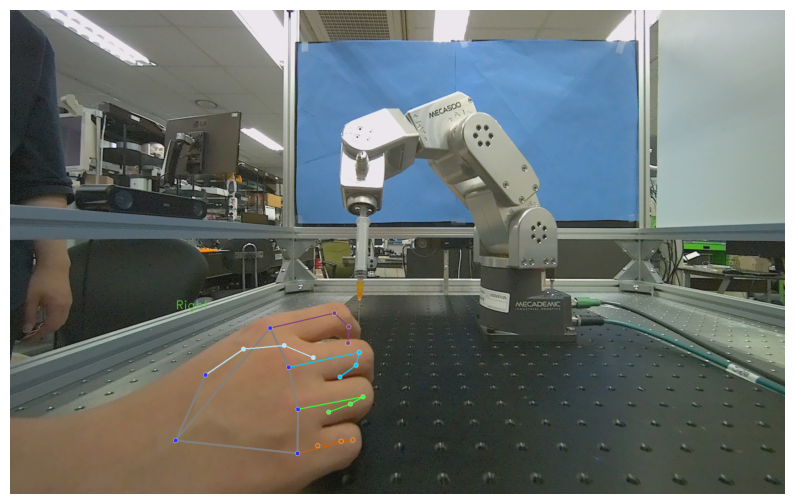

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import matplotlib.pyplot as plt
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_hand_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/Meca500_3D_Pose_Estimation/vla_dataset_insertion_250514_total/Left/images/train/zed_44377151_left_1747200970.709.jpg')

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()


I0000 00:00:1750235659.446869 2211849 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750235659.516753 2213336 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.144), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1750235659.623569 2213338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750235659.770834 2213347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


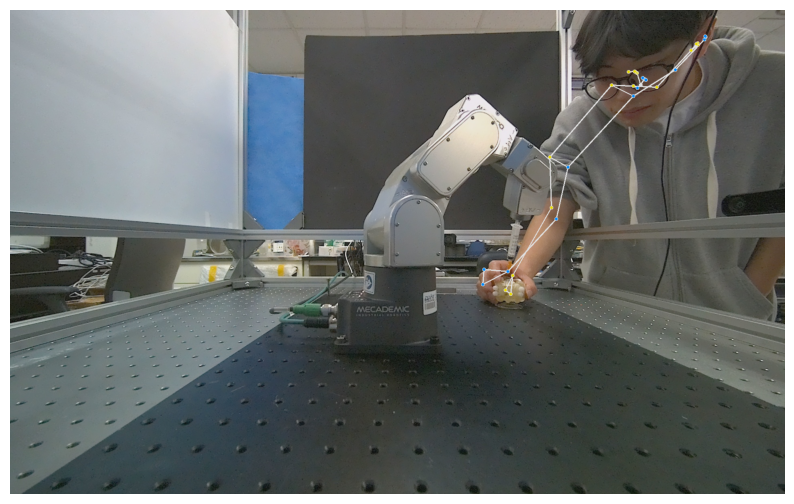

In [8]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/Meca500_3D_Pose_Estimation/vla_dataset_insertion_250514_total/Left/images/train/zed_44377151_left_1747200970.709.jpg')

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()